In [2]:
import cv2, imageio
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.ndimage import convolve

In [3]:
def GaussianBlur(src, ksize, sigmaX, sigmaY):
    '''
    INPUT:
    src: input image
    ksize: Gaussian kernel size, tuple or intger
    sigmaX: Gaussian kernel standard deviation in X direction 
    sigmaY: Gaussian kernel standard deviation in Y direction
    
    OUTPUT:
    dst: return image 
    '''
    #first create the gauss kernel
    if type(ksize) == int:
        ksize = (ksize, ksize)

    kernel = np.zeros(ksize)
    x0= ksize[0]//2
    y0 = ksize[1]//2
    for i in range(ksize[0]):
        for j in range(ksize[1]):
            kernel[i,j] = (1/(2*np.pi*sigmaX*sigmaY))*np.exp(-((i-x0)**2/(2*sigmaX**2) + (j-y0)**2/(2*sigmaY**2)))
    #normalize the kernel
    kernel = kernel/np.sum(kernel)

    #print(kernel)

    #convolve the image with the kernel

    # Create a new image with the same shape as the original image
    blurred_image = np.zeros_like(src)

    # Iterate over each channel in the image
    for channel in range(src.shape[2]):  # 对每个通道（R, G, B）
        blurred_image[..., channel] = convolve(src[..., channel], kernel, mode='reflect')

    return blurred_image

def medianBlur(src, ksize):
    '''
    INPUT:
    src: input image
    ksize: kernel size, tuple or intger
    
    OUTPUT:
    dst: return image 
    '''
    #write my own median filter
    #print(src.shape)
    # padding the image
    pad_size = ksize//2
    padded_image = np.pad(src, pad_size, mode='reflect')

    # Create a new image with the same shape as the original image
    blurred_image = np.zeros_like(src)

    # Iterate over each channel in the image
    for channel in range(src.shape[2]):  # 对每个通道（R, G, B）
        for i in range(src.shape[0]):
            for j in range(src.shape[1]):
                blurred_image[i,j,channel] = np.median(padded_image[i:i+ksize, j:j+ksize, channel])
    
    return blurred_image

def bilateralFilter(src, d, sigmaColor, sigmaSpace):
    '''
    输入参数:
    src: 输入图像 (H x W x C)
    d: 用于滤波的每个像素邻域的直径
    sigmaColor: 颜色空间中的滤波 sigma
    sigmaSpace: 坐标空间中的滤波 sigma

    输出:
    dst: 返回的图像
    '''
    half_d = d // 2

    # 计算空间核
    y, x = np.ogrid[-half_d:half_d + 1, -half_d:half_d + 1]
    space_kernel = np.exp(-(x**2 + y**2) / (2 * sigmaSpace**2))
    space_kernel /= np.sum(space_kernel)

    # 获取源图像的尺寸
    height, width, channels = src.shape

    # 创建输出图像
    filtered_image = np.zeros_like(src)

    # 遍历图像中的每个像素
    for channel in range(channels):
        for i in range(half_d, height - half_d):
            for j in range(half_d, width - half_d):
                # 提取邻域
                region = src[i - half_d:i + half_d + 1, j - half_d:j + half_d + 1, channel]

                # 计算颜色核
                color_diffs = region - src[i, j, channel]
                color_kernel = np.exp(-(color_diffs ** 2) / (2 * sigmaColor**2))
                color_kernel /= np.sum(color_kernel)

                # 计算组合核
                combined_kernel = color_kernel * space_kernel
                combined_kernel /= np.sum(combined_kernel)

                # 应用滤波器到每个通道
                filtered_image[i, j, channel] = np.sum(region * combined_kernel)

    return filtered_image










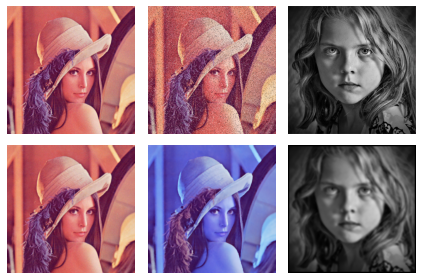

In [7]:
'''
学长，这一段代码的运行时间很长，大约有1分钟左右，主要是因为bilateralFilter函数占用了较长时间
'''
ga_lena_path = 'data/gaussian_lena.png'
sp_lena_path = 'data/sp_lena.png'
bi_girl_path = 'data/bilateral.jpg'

ga_lena = np.array(imageio.imread(ga_lena_path))
sp_lena = np.array(imageio.imread(sp_lena_path))
bi_girl = np.array(imageio.imread(bi_girl_path))


filter_ga_lena = GaussianBlur(ga_lena, (3, 3), sigmaX=1.0, sigmaY=1.0)
filter_sp_lena = medianBlur(sp_lena, ksize=5)
filter_bi_girl = bilateralFilter(bi_girl, d=15, sigmaColor=10, sigmaSpace=10)


ax = plt.subplot(231)
ax.axis('off')
ax.imshow(ga_lena)

ax = plt.subplot(232)
ax.axis('off')
ax.imshow(sp_lena)

ax = plt.subplot(233)
ax.axis('off')
ax.imshow(bi_girl)

ax = plt.subplot(234)
ax.axis('off')
ax.imshow(filter_ga_lena)

ax = plt.subplot(235)
ax.axis('off')
ax.imshow(filter_sp_lena)

ax = plt.subplot(236)
ax.axis('off')
ax.imshow(filter_bi_girl)

plt.tight_layout()
plt.show()

In [5]:
def project_and_show(model_path, fx, fy):
    '''
    Project the 3D model using perspective projection and show it in a 2D plane.
    INPUT:
    model_path: string, path of 3D model
    fx: focal length in X direction
    fy: focal length in Y direction
    
    OUTPUT:
    None
    '''
    # Load the point cloud
    pcd = o3d.io.read_point_cloud(model_path)
    points = np.asarray(pcd.points) # turn the point cloud into numpy array

    #turn the 3D points into homogenuous coordinates
    points = np.hstack([points, np.ones((points.shape[0], 1))])
    # print(points.shape)
    # print(points[0])

    # Define the projection matrix
    projection_matrix = np.array([[fx, 0, 0,0],
                  [0, fy, 0,0],
                  [0, 0, 1,0]])
    
    # Project the 3D points into 2D plane
    points = points @ projection_matrix.T
    # print(points.shape)
    # print(points[0])
    # print(points[1])

    # Normalize the points
    points /= points[:,2][:, np.newaxis]  # 归一化第三个坐标
    # print(points.shape)
    # print(points[0])
    # print(points[1])

    #extract the 2D points
    x = points[:,0]
    y = points[:,1]

    #the cat is upside down, so flip it
    y = -y


    #plot the 2D points
    plt.scatter(x, y)  
    plt.axis('off')
    plt.show()

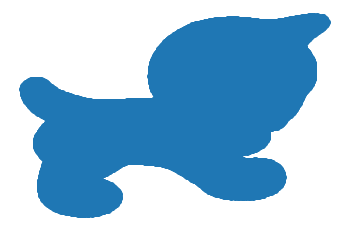

In [6]:
model_path, fx, fy = 'data/cat.ply', 572.4114, 573.57043
project_and_show(model_path, fx, fy)